Reconhecimento de Padrões

Lista 2: Regressão Polinomial

# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.datasets import load_iris

In [3]:
breast = pd.read_csv("content/breast.csv", header=None)
print(breast.shape)
breast.head()

(569, 31)


,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


In [23]:
iris = load_iris()
df_iris = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df_iris['target'] = iris.target
df_iris = df_iris.iloc[:, 2:]
df_iris.head()

,petal length (cm),petal width (cm),target
0,1.4,0.2,0
1,1.4,0.2,0
2,1.3,0.2,0
3,1.5,0.2,0
4,1.4,0.2,0


# Models

In [5]:
class GradientDescent:
  def __init__(self, alpha=0.1, epochs=10):
    self.alpha = alpha
    self.epochs = epochs
    self.w = []
    self.mse_per_epoch = []

  def fit(self, x, y, plot=False):
    x = x.copy()
    x.insert(0, "x0", 1)
    x = x.values

    self.w = np.zeros(x.shape[1])

    for epoch in range(self.epochs):
      error_list = []
      mse = 0

      for i in range(len(x)):
        y_hat = x[i] @ self.w
        error = y[i] - y_hat
        error_list.append(error * x[i])
        mse += error**2

      self.w += self.alpha * 1 / len(x) * sum(error_list)
      self.mse_per_epoch.append(mse / (2 * len(x)))

    return self.w

  def predict(self, x):
    x = x.copy()
    x.insert(0, "x0", 1)
    x = x.values

    return x @ self.w

In [6]:
class GradientDescentClassificator:
  def __init__(self, alpha=0.1, epochs=10, threshold = 0.5):
    self.alpha = alpha
    self.epochs = epochs
    self.w = []
    # self.mse_per_epoch = []
    self.threshold = threshold

  def sigmoid(self, x):
    return 1 / (1 + np.exp(-x))

  def fit(self, x, y, plot=False):
    x = x.copy()
    x.insert(0, "x0", 1)
    x = x.values

    self.w = np.zeros(x.shape[1])

    for epoch in range(self.epochs):
      error_list = []
      mse = 0
      for i in range(len(x)):
        y_hat = self.sigmoid(x[i] @ self.w)
        error = y[i] - y_hat
        error_list.append(error * x[i])
        mse += error**2

      self.w += self.alpha * 1 / len(x) * sum(error_list)
    #   self.mse_per_epoch.append(mse / (2 * len(x)))

    return self.w

  def predict(self, x):
    x = x.copy()
    x.insert(0, "x0", 1)
    x = x.values
    logreg = self.sigmoid(x @ self.w)
    return np.where(logreg >= self.threshold, 1, 0)

In [7]:
class Metrics():
  def __init__(self, y_true, y_pred):
    self.y_true = y_true
    self.y_pred = y_pred

    TP = 0
    FP = 0
    FN = 0

    for i in range(len(self.y_pred)):
      if self.y_true.values[i] == 1 and self.y_pred[i] == 1:
        TP += 1
      elif self.y_true.values[i] == 0 and self.y_pred[i] == 1:
        FP += 1
      elif self.y_true.values[i] == 1 and self.y_pred[i] == 0:
        FN += 1
    TN = len(self.y_true) - TP - FP - FN
    TP, FP, FN, TN

    self.TP = TP
    self.FP = FP
    self.FN = FN
    self.TN = TN

    self.accuracy = (self.TP + self.TN) / (self.TP + self.FP + self.FN + self.TN)
    self.precision = self.TP / (self.TP + self.FP)
    self.recall = self.TP / (self.TP + self.FN)
    self.f1_score = 2 * (self.precision * self.recall) / (self.precision + self.recall)
    
    self.confusion_matrix = np.array([[self.TN, self.FN], [self.FP, self.TP]])

# Q1) Breast_Cancer Dataset

## A) Logistic Regression

In [8]:
X_breast = breast.iloc[:, 0:-1]
y_breast = breast.iloc[:, -1]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_breast, y_breast, test_size=0.2, random_state=101)
x_max = X_train.max()
x_min = X_train.min()
X_train_norm = (X_train - x_min) / (x_max - x_min)
X_test_norm = (X_test - x_min) / (x_max - x_min)

In [10]:
gdc = GradientDescentClassificator(alpha=0.5, epochs=1000, threshold=0.5)
gdc.fit(X_train_norm, y_train.values)

array([ 7.49562291, -1.04521499, -1.31384532, -1.14640936, -1.46305948,
        0.38841194, -0.68029979, -2.41431889, -3.4527494 ,  0.24917195,
        2.0769212 , -1.6922423 ,  0.26831824, -1.27505434, -1.23528961,
        0.98282079,  1.04503576,  0.66738389,  0.31755659,  0.54183985,
        0.97222659, -2.2573409 , -2.22147207, -2.0598671 , -2.06475386,
       -1.1814897 , -1.04825205, -1.65703274, -3.32243219, -1.15351032,
       -0.1827314 ])

In [11]:
y_pred = gdc.predict(X_test_norm)

## B) Metrics

In [12]:
metric = Metrics(y_test, y_pred)

In [13]:
print("Accuracy:", metric.accuracy)
print("Precision:", metric.precision)
print("Recall:", metric.recall)
print("F1 Score:", metric.f1_score)

Accuracy: 0.9736842105263158
Precision: 0.9726027397260274
Recall: 0.9861111111111112
F1 Score: 0.9793103448275863


In [14]:
confusion_matrix = metric.confusion_matrix
confusion_matrix

array([[40,  1],
       [ 2, 71]])

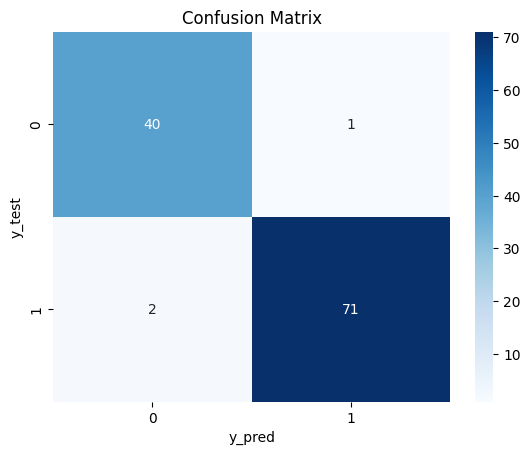

In [15]:
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.title('Confusion Matrix')
plt.show()

In [16]:
# plt.plot(range(len(gdc.mse_per_epoch)), gdc.mse_per_epoch)
# plt.xlabel("Epoch")
# plt.ylabel("MSE")
# plt.title("MSE per Epoch")
# plt.show()

## C) 10 Kfolds

In [17]:
gdc = GradientDescentClassificator(alpha=0.1, epochs=50, threshold=0.5)

In [18]:
kf = KFold(n_splits=10, shuffle=True, random_state = 101)
kf.get_n_splits(X_breast)

accuracy = []
precision = []
recall = []
f1_score = []

for i, (train_index, test_index) in enumerate(kf.split(X_breast)):
  X_train_fold, X_test_fold = X_breast.iloc[train_index], X_breast.iloc[test_index]
  y_train_fold, y_test_fold = y_breast.iloc[train_index], y_breast.iloc[test_index]

  x_max = X_train_fold.max()
  x_min = X_train_fold.min()
  X_train_norm = (X_train_fold - x_min) / (x_max - x_min)
  X_test_norm = (X_test_fold - x_min) / (x_max - x_min)
  gdc.fit(X_train_norm, y_train_fold.values)
  y_pred = gdc.predict(X_test_norm)
  metric = Metrics(y_test_fold, y_pred)

  accuracy.append(metric.accuracy)
  precision.append(metric.precision)
  recall.append(metric.recall)
  f1_score.append(metric.f1_score)

print("\naccuracy:", np.mean(accuracy), "\nSTD:", np.std(accuracy))
print("\nprecision:", np.mean(precision), "\nSTD:", np.std(precision))
print("\nrecall:", np.mean(recall), "\nSTD:", np.std(recall))
print("\nf1_score:", np.mean(f1_score), "\nSTD:", np.std(f1_score))


accuracy: 0.8680764411027567 
STD: 0.04504015709865375

precision: 0.8279990509584951 
STD: 0.053966016006587306

recall: 0.996875 
STD: 0.009375

f1_score: 0.9038024623289628 
STD: 0.03452705644876226


# Q2 Iris Decision Surface

In [24]:
df_iris.head()

,petal length (cm),petal width (cm),target
0,1.4,0.2,0
1,1.4,0.2,0
2,1.3,0.2,0
3,1.5,0.2,0
4,1.4,0.2,0


In [27]:
df_iris['target'] = df_iris['target'].replace(2, 1)
df_iris['target'].value_counts()

target
1    100
0     50
Name: count, dtype: int64

In [29]:
X_iris = df_iris.drop(['target'], axis=1)
y_iris = df_iris['target']

In [30]:
gdc = GradientDescentClassificator(alpha=0.1, epochs=1000, threshold=0.5)
gdc.fit(X_iris, y_iris.values)

array([-4.68298051,  1.30400179,  2.06737676])

In [32]:
y_pred = gdc.predict(X_iris)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [46]:
# Helper function to plot a decision boundary.
def plot_decision_boundary(pred_func, X):
  # Set min and max values and give it some padding
  # Use .iloc for DataFrame indexing
  x_min, x_max = X.iloc[:, 0].min() - .5, X.iloc[:, 0].max() + .5
  y_min, y_max = X.iloc[:, 1].min() - .5, X.iloc[:, 1].max() + .5
  h = 0.01
  # Generate a grid of points with distance h between them
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
  # Predict the function value for the whole gid
  # Convert the NumPy array to a Pandas DataFrame with correct column names
  Z = pred_func(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=X.columns)) # This line is changed to convert to a DataFrame
  Z = Z.reshape(xx.shape)
  # Plot the contour and training examples
  plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
  # Use .iloc for DataFrame indexing for scatter plot as well
  plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=plt.cm.Spectral)

In [47]:
plot_decision_boundary(lambda x: gdc.predict(X_iris), X_iris)
plt.title("Logistic Regression")

ValueError: cannot reshape array of size 150 into shape (340,690)